In [381]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso
import lightgbm as lgb

In [382]:
df = pd.read_csv('D:\Python\Zindi\Flood\Train.csv')

In [383]:
df['sqrt_elev'] = np.sqrt(df.elevation)


def haversine_dist(lat1,lng1,lat2,lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    radius = 6371  # Earth's radius taken from google
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat/2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng/2) ** 2
    h = 2 * radius * np.arcsin(np.sqrt(d))
    return h


def manhattan_dist(lat1, lng1, lat2, lng2):
    '''
    calculating two haversine distances by,
     - avoiding Latitude of one point 
     - avoiding Longitude of one point
    and adding it together.
    '''
    a = haversine_dist(lat1, lng1, lat1, lng2)
    b = haversine_dist(lat1, lng1, lat2, lng1)
    return a + b

df['manhattan_dist_center1'] = df.apply(lambda row: manhattan_dist(row['X'], row['Y'], 35.003815, -15.788289), axis=1)


temp = df['LC_Type1_mode'].value_counts().to_dict()
df['LC_Type1_counts'] = df['LC_Type1_mode'].map(temp)
features_2019 = []
features_2015 = []
for col in df.columns:
  if '2019' in col:
    features_2019.append(col)
  elif 'precip 2014' in col:
    features_2015.append(col)
  elif 'precip 2015' in col:
    features_2015.append(col)

In [384]:
train = df[df.columns.difference(features_2019)]
train.head()

,LC_Type1_counts,LC_Type1_mode,Square_ID,X,Y,elevation,manhattan_dist_center1,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,precip 2014-12-28 - 2015-01-04,precip 2015-01-04 - 2015-01-11,precip 2015-01-11 - 2015-01-18,precip 2015-01-18 - 2015-01-25,precip 2015-01-25 - 2015-02-01,precip 2015-02-01 - 2015-02-08,precip 2015-02-08 - 2015-02-15,precip 2015-02-15 - 2015-02-22,precip 2015-02-22 - 2015-03-01,precip 2015-03-01 - 2015-03-08,precip 2015-03-08 - 2015-03-15,sqrt_elev,target_2015
0,4008,9,4e3c3896-14ce-11ea-bce5-f49634744a41,34.26,-15.91,887.764222,93.893897,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,29.795372,0.0
1,4008,9,4e3c3897-14ce-11ea-bce5-f49634744a41,34.26,-15.90,743.403912,92.974880,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,27.265434,0.0
2,4008,9,4e3c3898-14ce-11ea-bce5-f49634744a41,34.26,-15.89,565.728343,92.055864,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,23.785045,0.0
3,4817,10,4e3c3899-14ce-11ea-bce5-f49634744a41,34.26,-15.88,443.392774,91.136847,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,21.056894,0.0
4,4817,10,4e3c389a-14ce-11ea-bce5-f49634744a41,34.26,-15.87,437.443428,90.217831,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,20.915148,0.0


In [385]:
list_of_features = ['X','Y','elevation','LC_Type1_mode','Square_ID','sqrt_elev', 'manhattan_dist_center1' ]

In [386]:
features_2019.extend(list_of_features)
test = df[features_2019]

In [387]:
new_2015_cols = {}
for col, number in zip(features_2015, range(1, len(features_2015) + 1)):
  if 'precip' in col:
    new_2015_cols[col] = 'week_' + str(number) + '_precip'


new_2019_cols = {}
for col, number in zip(features_2019, range(1, len(features_2019) + 1)):
  if 'precip' in col:
    new_2019_cols[col] = 'week_' + str(number) + '_precip'
    
train.rename(columns = new_2015_cols, inplace = True)
test.rename(columns = new_2019_cols, inplace = True)

In [388]:
def target_encoding(df, features, dicts_encoded):
    for i in range(len(dicts_encoded)):
        for j in range(len(features)):
            df['{}_{}'.format(features[j], i)] = df[features[j]].map(dicts_encoded[i])
    return df

def make_conj(df, feature1, feature2):
    return df['{}'.format(feature1)] * df['{}'.format(feature2)]

In [389]:
#Target Encoding
std_ = train.groupby('LC_Type1_mode')['target_2015'].std()
median_ = train.groupby('LC_Type1_mode')['target_2015'].median()
mean_ = train.groupby('LC_Type1_mode')['target_2015'].mean()
skew_ = train.groupby('LC_Type1_mode')['target_2015'].skew()
train = target_encoding(train, ['LC_Type1_mode'], [std_, median_, mean_, skew_])
test = target_encoding(test, ['LC_Type1_mode'], [std_, median_, mean_, skew_])

In [390]:
train.head()

,LC_Type1_counts,LC_Type1_mode,Square_ID,X,Y,elevation,manhattan_dist_center1,week_1_precip,week_2_precip,week_3_precip,week_4_precip,week_5_precip,week_6_precip,week_7_precip,week_8_precip,week_9_precip,week_10_precip,week_11_precip,week_12_precip,week_13_precip,week_14_precip,week_15_precip,week_16_precip,week_17_precip,sqrt_elev,target_2015,LC_Type1_mode_0,LC_Type1_mode_1,LC_Type1_mode_2,LC_Type1_mode_3
0,4008,9,4e3c3896-14ce-11ea-bce5-f49634744a41,34.26,-15.91,887.764222,93.893897,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,29.795372,0.0,0.123044,0.0,0.028854,5.771743
1,4008,9,4e3c3897-14ce-11ea-bce5-f49634744a41,34.26,-15.90,743.403912,92.974880,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,27.265434,0.0,0.123044,0.0,0.028854,5.771743
2,4008,9,4e3c3898-14ce-11ea-bce5-f49634744a41,34.26,-15.89,565.728343,92.055864,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,23.785045,0.0,0.123044,0.0,0.028854,5.771743
3,4817,10,4e3c3899-14ce-11ea-bce5-f49634744a41,34.26,-15.88,443.392774,91.136847,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,21.056894,0.0,0.220345,0.0,0.074327,3.146144
4,4817,10,4e3c389a-14ce-11ea-bce5-f49634744a41,34.26,-15.87,437.443428,90.217831,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,20.915148,0.0,0.220345,0.0,0.074327,3.146144


In [391]:
pd.set_option('display.max_columns', 17000)
pd.set_option('display.max_row', 17000)

In [392]:
train.shape

(16466, 30)

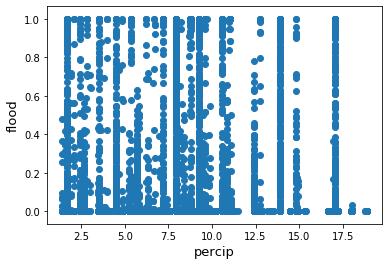

In [393]:
fig, ax = plt.subplots()
ax.scatter(x = train['week_4_precip'], y = train['target_2015'])
plt.ylabel('flood', fontsize=13)
plt.xlabel('percip', fontsize=13)
plt.show()

([array([1388., 1060.,  914.,  750., 2280., 1383., 2090., 2051.,  359.,
          845.,  815.,   64.,  618.,  539.,  287.,  627.,  378.,   18.,
            0.,    0.]),
  array([   0.,   22., 1180., 1187., 1346., 2277., 1501., 2527., 1883.,
          836.,   48.,  625.,  666.,  192.,   25.,  375., 1176.,    0.,
            0.,  600.])],
 array([ 1.41145229,  2.43828754,  3.46512279,  4.49195803,  5.51879328,
         6.54562853,  7.57246377,  8.59929902,  9.62613426, 10.65296951,
        11.67980476, 12.70664   , 13.73347525, 14.7603105 , 15.78714574,
        16.81398099, 17.84081624, 18.86765148, 19.89448673, 20.92132197,
        21.94815722]),
 <a list of 2 Lists of Patches objects>)

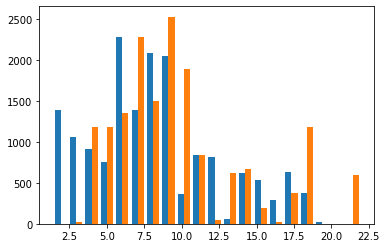

In [394]:
plt.hist([train.week_4_precip, test.week_4_precip], bins = 20)

(array([14163.,   224.,   188.,   140.,   125.,   140.,    98.,    85.,
           75.,    74.,    65.,    71.,    60.,    57.,    67.,    58.,
           59.,    75.,    98.,   544.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

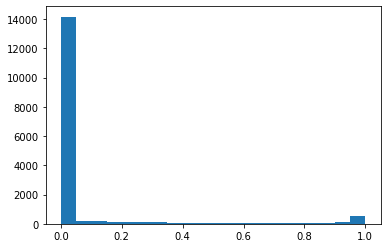

In [395]:
plt.hist([train.target_2015], bins = 20)

In [396]:
train.describe()

,LC_Type1_counts,LC_Type1_mode,X,Y,elevation,manhattan_dist_center1,week_1_precip,week_2_precip,week_3_precip,week_4_precip,week_5_precip,week_6_precip,week_7_precip,week_8_precip,week_9_precip,week_10_precip,week_11_precip,week_12_precip,week_13_precip,week_14_precip,week_15_precip,week_16_precip,week_17_precip,sqrt_elev,target_2015,LC_Type1_mode_0,LC_Type1_mode_1,LC_Type1_mode_2,LC_Type1_mode_3
count,16466.000000,16466.00000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16465.000000,16466.000000,16466.000000,16465.000000
mean,4715.326491,10.73175,35.077656,-15.813802,592.848206,64.306257,1.610760,2.502058,1.162076,8.270610,8.892459,9.572821,22.925036,28.113210,58.859208,1.251173,34.653177,28.314888,12.487909,3.802584,17.072285,9.110949,0.330641,23.110613,0.076609,0.211964,0.001965,0.076609,3.835180
std,1616.302378,2.02610,0.392395,0.359789,354.790357,26.134587,4.225461,8.631846,4.396676,4.263375,3.760052,4.523767,13.690451,7.794291,16.807838,1.969923,7.456422,8.047223,7.064435,2.674434,6.074926,4.572201,1.008490,7.664943,0.228734,0.071723,0.019476,0.047670,2.029661
min,1.000000,2.00000,34.260000,-16.640000,45.541444,0.580056,0.000000,0.000000,0.000000,1.411452,3.580342,1.254098,7.462999,15.648154,30.449468,0.000000,14.964383,13.261280,0.459067,0.279002,6.728685,3.283425,0.000000,6.748440,0.000000,0.040178,0.000000,0.000000,0.385955
25%,4008.000000,9.00000,34.760000,-16.070000,329.063852,45.650096,0.000000,0.000000,0.000000,5.548440,5.905440,6.179885,11.617057,23.483879,45.972601,0.000000,30.037450,22.262417,5.090802,1.654155,13.769957,5.538848,0.000000,18.140117,0.000000,0.123044,0.000000,0.028854,2.463416
50%,4817.000000,10.00000,35.050000,-15.800000,623.000000,65.119976,0.000000,0.000000,0.000000,7.941822,8.618390,8.786780,18.381539,26.085586,55.501115,0.502164,34.363729,26.512675,14.092012,3.301029,15.549508,8.235819,0.000000,24.959968,0.000000,0.220345,0.000000,0.074327,3.146144
75%,6151.000000,12.00000,35.390000,-15.520000,751.434813,82.515562,1.261848,0.000000,0.000000,10.887235,10.960668,12.670775,31.304699,33.587434,69.311540,1.195866,36.715386,34.880240,18.681926,5.120276,19.836449,11.308650,0.000000,27.412311,0.000000,0.279213,0.000000,0.110866,5.771743
max,6151.000000,17.00000,35.860000,-15.210000,2803.303645,140.888973,19.354969,41.023858,22.020803,18.870675,23.044340,21.757828,62.433432,51.197420,105.275891,11.103658,53.014243,44.341312,28.559923,15.715008,36.964993,25.711649,4.953321,52.946234,1.000000,0.418285,0.194949,0.399362,11.959546


In [397]:
#remove outliers
train = train[train.week_4_precip >= 5] #5
train = train[train.target_2015 < 1]

#feature transformation
train['X'] = train.X**2
target = (train.target_2015+2)**2
train, test = train.align(test, join = 'inner', axis = 1)
train.loc[:, 'week_1_precip':'week_17_precip'] = (train.loc[:, 'week_1_precip':'week_17_precip'] + 2)**2
test.loc[:, 'week_1_precip':'week_17_precip'] = (test.loc[:, 'week_1_precip':'week_17_precip'] + 2)**2
train['1*2'] = make_conj(train, 'week_1_precip', 'week_2_precip')
train['3*4'] = make_conj(train, 'week_3_precip', 'week_4_precip')
test['1*2'] = make_conj(test, 'week_1_precip', 'week_2_precip')
test['3*4'] = make_conj(test, 'week_3_precip', 'week_4_precip')

([array([1480.,    0.,    0.,   26.,    0.,    7.,    0.,    0.,    0.,
           38.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,  196.]),
  array([15020.,   822.,   624.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.])],
 array([1.60000000e+01, 4.22224068e+04, 8.44288137e+04, 1.26635220e+05,
        1.68841627e+05, 2.11048034e+05, 2.53254441e+05, 2.95460848e+05,
        3.37667255e+05, 3.79873661e+05, 4.22080068e+05, 4.64286475e+05,
        5.06492882e+05, 5.48699289e+05, 5.90905696e+05, 6.33112102e+05,
        6.75318509e+05, 7.17524916e+05, 7.59731323e+05, 8.01937730e+05,
        8.44144137e+05]),
 <a list of 2 Lists of Patches objects>)

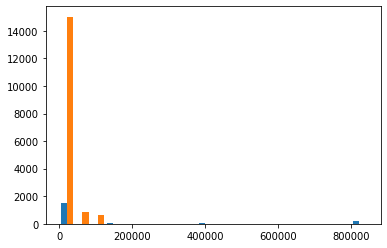

In [398]:
plt.hist([train['1*2'], test['1*2']], bins = 20)

([array([1513.,   38.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          196.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.]),
  array([ 672., 1545., 1942., 2068., 1748., 3383.,  567.,  715., 1139.,
          605.,   51.,  673.,   29.,    0.,    0.,   26.,   15.,   24.,
           24., 1240.])],
 array([2.08535620e+02, 1.55123297e+04, 3.08161237e+04, 4.61199177e+04,
        6.14237117e+04, 7.67275058e+04, 9.20312998e+04, 1.07335094e+05,
        1.22638888e+05, 1.37942682e+05, 1.53246476e+05, 1.68550270e+05,
        1.83854064e+05, 1.99157858e+05, 2.14461652e+05, 2.29765446e+05,
        2.45069240e+05, 2.60373034e+05, 2.75676828e+05, 2.90980622e+05,
        3.06284416e+05]),
 <a list of 2 Lists of Patches objects>)

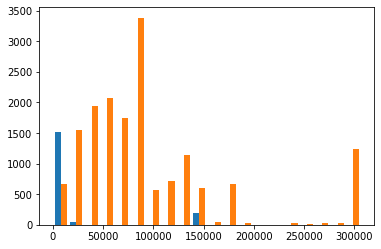

In [399]:
plt.hist([train['3*4'], test['3*4']], bins = 20)

In [400]:
train.head()

,LC_Type1_mode,Square_ID,X,Y,elevation,manhattan_dist_center1,week_1_precip,week_2_precip,week_3_precip,week_4_precip,week_5_precip,week_6_precip,week_7_precip,week_8_precip,week_9_precip,week_10_precip,week_11_precip,week_12_precip,week_13_precip,week_14_precip,week_15_precip,week_16_precip,week_17_precip,sqrt_elev,LC_Type1_mode_0,LC_Type1_mode_1,LC_Type1_mode_2,LC_Type1_mode_3,1*2,3*4
14,10,4e3c38a4-14ce-11ea-bce5-f49634744a41,1174.4329,-15.87,408.447004,89.104989,4.0,4.0,4.0,283.721185,273.995951,202.713994,3534.464282,1032.147159,1052.967961,12.403276,985.331811,1216.497069,103.628407,8.785186,348.161891,28.137361,4.0,20.210072,0.220345,0.0,0.074327,3.146144,16.0,1134.884739
15,10,4e3c38a5-14ce-11ea-bce5-f49634744a41,1174.4329,-15.86,394.483769,88.186082,4.0,4.0,4.0,283.721185,273.995951,202.713994,3534.464282,1032.147159,1052.967961,12.403276,985.331811,1216.497069,103.628407,8.785186,348.161891,28.137361,4.0,19.861615,0.220345,0.0,0.074327,3.146144,16.0,1134.884739
256,9,4e3c3996-14ce-11ea-bce5-f49634744a41,1181.9844,-15.75,647.686005,72.878858,4.0,4.0,4.0,253.675454,340.049978,157.706848,3680.751871,1082.603193,1207.441581,15.354861,868.860267,1419.811287,110.023656,8.864112,371.007462,28.082822,4.0,25.449676,0.123044,0.0,0.028854,5.771743,16.0,1014.701816
257,9,4e3c3997-14ce-11ea-bce5-f49634744a41,1181.9844,-15.74,645.718854,73.796562,4.0,4.0,4.0,171.435686,589.271210,54.266236,4151.667183,1246.170318,1751.725352,26.467833,555.158278,2147.517229,131.001335,9.110296,446.210472,27.914580,4.0,25.410999,0.123044,0.0,0.028854,5.771743,16.0,685.742743
258,9,4e3c3998-14ce-11ea-bce5-f49634744a41,1181.9844,-15.73,647.138562,74.714265,4.0,4.0,4.0,171.435686,589.271210,54.266236,4151.667183,1246.170318,1751.725352,26.467833,555.158278,2147.517229,131.001335,9.110296,446.210472,27.914580,4.0,25.438918,0.123044,0.0,0.028854,5.771743,16.0,685.742743


In [401]:
list_of_precip = ['week_{}_precip'.format(i) for i in range(1, 18)]

In [403]:
                         
pca = PCA(n_components = 0.98)
precip_train = pd.DataFrame(pca.fit_transform(train.loc[:, 'week_1_precip':'week_17_precip']))
precip_train=precip_train.set_axis(['a', 'b', 'c', 'd', 'e', 'f'], axis=1, inplace=False)
train.drop(columns = list_of_precip, inplace = True)
train = train.reset_index().drop('index', axis = 1)
train = pd.concat([train, precip_train], axis = 1)
precip_test = pd.DataFrame(pca.fit_transform(test.loc[:, 'week_1_precip':'week_17_precip']))
precip_test = precip_test.set_axis(['a', 'b', 'c', 'd', 'e', 'f'], axis=1, inplace=False)
test.drop(columns = list_of_precip, inplace = True)
test = pd.concat([test, precip_test], axis = 1)

In [404]:
median = train.groupby('LC_Type1_mode')['sqrt_elev'].median()
train['Type1_median_sqrt_elev'] = train['LC_Type1_mode'].map(median)

median = test.groupby('LC_Type1_mode')['sqrt_elev'].median()
test['Type1_median_sqrt_elev'] = test['LC_Type1_mode'].map(median)

In [405]:
train.head()

,LC_Type1_mode,Square_ID,X,Y,elevation,manhattan_dist_center1,sqrt_elev,LC_Type1_mode_0,LC_Type1_mode_1,LC_Type1_mode_2,LC_Type1_mode_3,1*2,3*4,0,1,2,3,4,Type1_median_sqrt_elev
0,10,4e3c38a4-14ce-11ea-bce5-f49634744a41,1174.4329,-15.87,408.447004,89.104989,20.210072,0.220345,0.0,0.074327,3.146144,16.0,1134.884739,-2924.737115,2884.919637,1116.956273,402.129093,73.901529,8.713425
1,10,4e3c38a5-14ce-11ea-bce5-f49634744a41,1174.4329,-15.86,394.483769,88.186082,19.861615,0.220345,0.0,0.074327,3.146144,16.0,1134.884739,-2924.737115,2884.919637,1116.956273,402.129093,73.901529,8.713425
2,9,4e3c3996-14ce-11ea-bce5-f49634744a41,1181.9844,-15.75,647.686005,72.878858,25.449676,0.123044,0.0,0.028854,5.771743,16.0,1014.701816,-2779.779225,3047.530888,1146.392409,436.738480,-18.899415,18.719542
3,9,4e3c3997-14ce-11ea-bce5-f49634744a41,1181.9844,-15.74,645.718854,73.796562,25.410999,0.123044,0.0,0.028854,5.771743,16.0,685.742743,-2270.138527,3590.920638,1188.741922,515.145406,-284.879968,18.719542
4,9,4e3c3998-14ce-11ea-bce5-f49634744a41,1181.9844,-15.73,647.138562,74.714265,25.438918,0.123044,0.0,0.028854,5.771743,16.0,685.742743,-2270.138527,3590.920638,1188.741922,515.145406,-284.879968,18.719542


In [406]:
test.head()

,LC_Type1_mode,Square_ID,X,Y,elevation,manhattan_dist_center1,sqrt_elev,LC_Type1_mode_0,LC_Type1_mode_1,LC_Type1_mode_2,LC_Type1_mode_3,1*2,3*4,0,1,2,3,4,5,Type1_median_sqrt_elev
0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,34.26,-15.91,887.764222,93.893897,29.795372,0.123044,0.0,0.028854,5.771743,9740.555848,63356.672543,-938.907049,937.999797,-373.987098,-450.332485,80.252546,-353.254929,24.738116
1,9,4e3c3897-14ce-11ea-bce5-f49634744a41,34.26,-15.90,743.403912,92.974880,27.265434,0.123044,0.0,0.028854,5.771743,9740.555848,63356.672543,-938.907049,937.999797,-373.987098,-450.332485,80.252546,-353.254929,24.738116
2,9,4e3c3898-14ce-11ea-bce5-f49634744a41,34.26,-15.89,565.728343,92.055864,23.785045,0.123044,0.0,0.028854,5.771743,9740.555848,63356.672543,-938.907049,937.999797,-373.987098,-450.332485,80.252546,-353.254929,24.738116
3,10,4e3c3899-14ce-11ea-bce5-f49634744a41,34.26,-15.88,443.392774,91.136847,21.056894,0.220345,0.0,0.074327,3.146144,9740.555848,63356.672543,-938.907049,937.999797,-373.987098,-450.332485,80.252546,-353.254929,18.241503
4,10,4e3c389a-14ce-11ea-bce5-f49634744a41,34.26,-15.87,437.443428,90.217831,20.915148,0.220345,0.0,0.074327,3.146144,9740.555848,63356.672543,-938.907049,937.999797,-373.987098,-450.332485,80.252546,-353.254929,18.241503


In [407]:
target.head()

14     4.283797
15     4.649081
256    4.053475
257    6.239873
258    5.287641
Name: target_2015, dtype: float64

In [408]:
test.shape, train.shape

((16466, 20), (1747, 19))

# LGBM modeling

In [409]:
X = train.drop(['Square_ID'], axis = 1)
y = target

params = {
    'boosting_type':  'gbdt',
    'num_iterations': 39000, #39000
    'metric': 'rmse',
    'objective': 'regression',
    'n_jobs': -1,
    'seed': 236,
    'learning_rate': 0.015, #0.015
    'bagging_fraction': 0.85,
    'bagging_freq': 10, 
    'colsample_bytree': 0.75

}



train_set = lgb.Dataset(X,y)
val_set = lgb.Dataset(X,y)

model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 200, valid_sets = [train_set, val_set], verbose_eval = 50)
val_pred = model.predict(X)
val_score = mean_squared_error(val_pred, y, 
                              )
print(f'Our val mse score is {val_score}')

Training until validation scores don't improve for 200 rounds
[50]	training's rmse: 1.19226	valid_1's rmse: 1.19226
[100]	training's rmse: 1.01887	valid_1's rmse: 1.01887
[150]	training's rmse: 0.941538	valid_1's rmse: 0.941538
[200]	training's rmse: 0.893294	valid_1's rmse: 0.893294
[250]	training's rmse: 0.862216	valid_1's rmse: 0.862216
[300]	training's rmse: 0.836877	valid_1's rmse: 0.836877
[350]	training's rmse: 0.81381	valid_1's rmse: 0.81381
[400]	training's rmse: 0.793619	valid_1's rmse: 0.793619
[450]	training's rmse: 0.777005	valid_1's rmse: 0.777005
[500]	training's rmse: 0.760961	valid_1's rmse: 0.760961
[550]	training's rmse: 0.745435	valid_1's rmse: 0.745435
[600]	training's rmse: 0.732298	valid_1's rmse: 0.732298
[650]	training's rmse: 0.718646	valid_1's rmse: 0.718646
[700]	training's rmse: 0.706139	valid_1's rmse: 0.706139
[750]	training's rmse: 0.694062	valid_1's rmse: 0.694062
[800]	training's rmse: 0.683745	valid_1's rmse: 0.683745
[850]	training's rmse: 0.67322	va

[7100]	training's rmse: 0.257827	valid_1's rmse: 0.257827
[7150]	training's rmse: 0.256525	valid_1's rmse: 0.256525
[7200]	training's rmse: 0.255147	valid_1's rmse: 0.255147
[7250]	training's rmse: 0.253803	valid_1's rmse: 0.253803
[7300]	training's rmse: 0.252485	valid_1's rmse: 0.252485
[7350]	training's rmse: 0.251255	valid_1's rmse: 0.251255
[7400]	training's rmse: 0.250078	valid_1's rmse: 0.250078
[7450]	training's rmse: 0.248755	valid_1's rmse: 0.248755
[7500]	training's rmse: 0.247502	valid_1's rmse: 0.247502
[7550]	training's rmse: 0.246301	valid_1's rmse: 0.246301
[7600]	training's rmse: 0.245073	valid_1's rmse: 0.245073
[7650]	training's rmse: 0.243911	valid_1's rmse: 0.243911
[7700]	training's rmse: 0.242567	valid_1's rmse: 0.242567
[7750]	training's rmse: 0.241416	valid_1's rmse: 0.241416
[7800]	training's rmse: 0.240278	valid_1's rmse: 0.240278
[7850]	training's rmse: 0.239006	valid_1's rmse: 0.239006
[7900]	training's rmse: 0.237799	valid_1's rmse: 0.237799
[7950]	trainin

[14100]	training's rmse: 0.137708	valid_1's rmse: 0.137708
[14150]	training's rmse: 0.137191	valid_1's rmse: 0.137191
[14200]	training's rmse: 0.136695	valid_1's rmse: 0.136695
[14250]	training's rmse: 0.136145	valid_1's rmse: 0.136145
[14300]	training's rmse: 0.135623	valid_1's rmse: 0.135623
[14350]	training's rmse: 0.135095	valid_1's rmse: 0.135095
[14400]	training's rmse: 0.134589	valid_1's rmse: 0.134589
[14450]	training's rmse: 0.134096	valid_1's rmse: 0.134096
[14500]	training's rmse: 0.133543	valid_1's rmse: 0.133543
[14550]	training's rmse: 0.133013	valid_1's rmse: 0.133013
[14600]	training's rmse: 0.132487	valid_1's rmse: 0.132487
[14650]	training's rmse: 0.13196	valid_1's rmse: 0.13196
[14700]	training's rmse: 0.131482	valid_1's rmse: 0.131482
[14750]	training's rmse: 0.13099	valid_1's rmse: 0.13099
[14800]	training's rmse: 0.130461	valid_1's rmse: 0.130461
[14850]	training's rmse: 0.129961	valid_1's rmse: 0.129961
[14900]	training's rmse: 0.129448	valid_1's rmse: 0.129448
[

[20950]	training's rmse: 0.0839502	valid_1's rmse: 0.0839502
[21000]	training's rmse: 0.0836642	valid_1's rmse: 0.0836642
[21050]	training's rmse: 0.0833996	valid_1's rmse: 0.0833996
[21100]	training's rmse: 0.0831085	valid_1's rmse: 0.0831085
[21150]	training's rmse: 0.0828409	valid_1's rmse: 0.0828409
[21200]	training's rmse: 0.0825632	valid_1's rmse: 0.0825632
[21250]	training's rmse: 0.0823079	valid_1's rmse: 0.0823079
[21300]	training's rmse: 0.0820273	valid_1's rmse: 0.0820273
[21350]	training's rmse: 0.0817776	valid_1's rmse: 0.0817776
[21400]	training's rmse: 0.0815371	valid_1's rmse: 0.0815371
[21450]	training's rmse: 0.0812736	valid_1's rmse: 0.0812736
[21500]	training's rmse: 0.0809692	valid_1's rmse: 0.0809692
[21550]	training's rmse: 0.0807125	valid_1's rmse: 0.0807125
[21600]	training's rmse: 0.0804003	valid_1's rmse: 0.0804003
[21650]	training's rmse: 0.0801285	valid_1's rmse: 0.0801285
[21700]	training's rmse: 0.0798791	valid_1's rmse: 0.0798791
[21750]	training's rmse:

[27650]	training's rmse: 0.0548698	valid_1's rmse: 0.0548698
[27700]	training's rmse: 0.054723	valid_1's rmse: 0.054723
[27750]	training's rmse: 0.0545541	valid_1's rmse: 0.0545541
[27800]	training's rmse: 0.0543928	valid_1's rmse: 0.0543928
[27850]	training's rmse: 0.0542537	valid_1's rmse: 0.0542537
[27900]	training's rmse: 0.0541051	valid_1's rmse: 0.0541051
[27950]	training's rmse: 0.0539509	valid_1's rmse: 0.0539509
[28000]	training's rmse: 0.0537698	valid_1's rmse: 0.0537698
[28050]	training's rmse: 0.0536225	valid_1's rmse: 0.0536225
[28100]	training's rmse: 0.0534408	valid_1's rmse: 0.0534408
[28150]	training's rmse: 0.0532938	valid_1's rmse: 0.0532938
[28200]	training's rmse: 0.0531387	valid_1's rmse: 0.0531387
[28250]	training's rmse: 0.0529767	valid_1's rmse: 0.0529767
[28300]	training's rmse: 0.0528092	valid_1's rmse: 0.0528092
[28350]	training's rmse: 0.0526535	valid_1's rmse: 0.0526535
[28400]	training's rmse: 0.0524954	valid_1's rmse: 0.0524954
[28450]	training's rmse: 0

[34350]	training's rmse: 0.0373447	valid_1's rmse: 0.0373447
[34400]	training's rmse: 0.037255	valid_1's rmse: 0.037255
[34450]	training's rmse: 0.0371487	valid_1's rmse: 0.0371487
[34500]	training's rmse: 0.0370385	valid_1's rmse: 0.0370385
[34550]	training's rmse: 0.0369373	valid_1's rmse: 0.0369373
[34600]	training's rmse: 0.0368404	valid_1's rmse: 0.0368404
[34650]	training's rmse: 0.0367438	valid_1's rmse: 0.0367438
[34700]	training's rmse: 0.0366427	valid_1's rmse: 0.0366427
[34750]	training's rmse: 0.0365368	valid_1's rmse: 0.0365368
[34800]	training's rmse: 0.0364352	valid_1's rmse: 0.0364352
[34850]	training's rmse: 0.0363316	valid_1's rmse: 0.0363316
[34900]	training's rmse: 0.0362329	valid_1's rmse: 0.0362329
[34950]	training's rmse: 0.0361297	valid_1's rmse: 0.0361297
[35000]	training's rmse: 0.0360408	valid_1's rmse: 0.0360408
[35050]	training's rmse: 0.0359333	valid_1's rmse: 0.0359333
[35100]	training's rmse: 0.0358311	valid_1's rmse: 0.0358311
[35150]	training's rmse: 0

In [410]:
sub = test.drop(['Square_ID'], axis = 1)
predictions  = model.predict(sub) 
predictions = np.sqrt(predictions) - 2
predictions[predictions < 0] = 0
predictions -= 0.268 
predictions[predictions < 0] = 0
submission = pd.DataFrame({'Square_ID': test.Square_ID, 'target_2019': predictions}) # Creating a submission file
submission.to_csv('D:\Python\Zindi\Flood\submission1.csv', index = False)